# Oficina de dados na disciplina de Modelagem Informacional

## Oficina de dados de vacinação de covid com serviços da nuvem AWS

### Desafio individual

Ler os dados públicos de vacinação da covid-19 do seu estado e montar um indicador de percentual da população de vacinados por município. A projeção de população por município está no site do IBGE.

### Recursos necessários

Espaço de armazenamento e de processamento na nuvem da AWS (já disponível).
Dados de vacinação do DATASUS (já disponível).
Dados populacionais do IBGE.

### Entrega

- Procure problemas de qualidade nos seus dados e responda as perguntas abaixo:
  - Existem registros repetidos?
  - Existem pessoas que tomaram mais de 3 doses da vacina?
  - A quantidade de vacinados na primeira dose é superior ou igual a quantidade na segunda?
  - Descubra como fazer um JOIN entre as duas tabelas carregadas e monte uma tabela listando o nome do município, o respectivo código do IBGE, e o percentual da população vacinada por município.

#### Bônus

Apresentar e explicar qualquer visualização interessante dos seus dados. Se quiser, pode exportar e fazer no power BI.

### Orientações gerais - fase 1

Use a região padrão Norte de Virgínia.
Sempre que tiver um campo perguntando sobre "IAM Role" escolha "LabRole".

1. Iniciar o seu lab na sua conta AWS Academy no curso Learner Lab.
2. Criar um bucket no S3 chamado cache-athena-<<número aleatório>>.
3. Criar um bucket no S3 chamado oficina-<<número aleatório>>. Criar subpastas oficina-<<número aleatório>>/opendatasus/mg/, oficina-<<número aleatório>>/opendatasus/zonabruta/covid-vac-mg-1
4. Criar um notebook no SageMaker com todas as opções padrão. Abrir este arquivo com o motor "conda_pytorch_p310".
5. Fazer o download de um arquivo de vacinação da parte1 de MG https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao
6. Carregar no bucket S3 oficina-<<número aleatório>>.
7. Usar o Glue para usar o CSV como uma tabela no formato AVRO no Athena.
8. Brincar com análises básicas.
9. Fazer download https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?=&t=downloads
10. Carregar no S3 como uma nova tabela, seguindo passos similares aos da vacinação.

### Ver espaço livre em disco

Você vai precisar desse espaço para manipular os arquivos antes de subir ao S3. Vemos 48G livres.

In [1]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        1.9G     0  1.9G   0% /dev
tmpfs           1.9G     0  1.9G   0% /dev/shm
tmpfs           1.9G  580K  1.9G   1% /run
tmpfs           1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/nvme0n1p1  135G   88G   48G  65% /
/dev/nvme1n1    4.8G  524K  4.6G   1% /home/ec2-user/SageMaker
tmpfs           386M     0  386M   0% /run/user/1001
tmpfs           386M     0  386M   0% /run/user/1002
tmpfs           386M     0  386M   0% /run/user/1000


#### Download da parte 1 de MG no opendatasus

Abra o portal https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao e procure o arquivo, pois a URL muda de padrão diariamente.
Abaixo:
1. download para o "/tmp"
2. validação "ls..."
3. ver o cabeçalho do arquivo. Vemos um arquivo delimitado por aspas e separado por ';'
4. copiar arquivo para bucket oficina-<<número aleatório>>/opendatasus/mg/

In [3]:
!curl https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIPNI/COVID/uf/uf%3DMG/part-00000-5580d8df-adc6-41ea-8887-eedaa63c1f78.c000.csv -o /tmp/covid-vac-mg-1.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   243    0   243    0     0    655      0 --:--:-- --:--:-- --:--:--   656


In [5]:
!ls -lh /tmp/covid*

-rw-rw-r-- 1 ec2-user ec2-user 243 May 25 14:28 /tmp/covid-vac-mg-1.csv


In [6]:
!head -n 3 /tmp/covid-vac-mg-1.csv

<?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied</Message><RequestId>6JCWQM5PH2RJK4MM</RequestId><HostId>xW9haAI2pc3RSNgCROaIEez+8hcW44L0WMrl438vTFyc75UDyzzrWbIT7ieY1ia5M4mLRS053Ak=</HostId></Error>

In [ ]:
file_name = "/tmp/covid-vac-mg-1.csv"

import boto3

s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'oficina-17045', 'opendatasus/mg/covid-vac-mg-1.csv')

### Orientações gerais - fase 2

#### Catalogar no Glue

1. Abrir AWS Glue
2. Criar database oficina
3. Criar tabela oficina.forma-vazia-covid-vac-mg-1 em s3://oficina-0973/opendatasus/zonabruta/covid-vac-mg-1 e colar o esquema json abaixo, escolher o formato 'avro'
4. Novo visual ETL, origem = S3 bucket apontando para oficina-0973/opendatasus/mg/covid-vac-mg-1.csv
5. Ainda no ETL, destino = AWS Glue data catalog apontando para a tabela vazia criada em (3), rodar o job, certifique-e de escolher "Update schema and add new partitions"
6. Criar um novo crawler para ler o local s3://oficina-0973/opendatasus/zonabruta/covid-vac-mg-1

Você terá uma nova tabela "oficina"."covid-vac-mg-1".

##### Tabela de vacinação em formato json:

[
  {
    "Name": "document_id",
    "Type": "string"
  },
  {
    "Name": "paciente_id",
    "Type": "string"
  },
  {
    "Name": "paciente_idade",
    "Type": "bigint"
  },
  {
    "Name": "paciente_datanascimento",
    "Type": "string"
  },
  {
    "Name": "paciente_enumsexobiologico",
    "Type": "string"
  },
  {
    "Name": "paciente_racacor_codigo",
    "Type": "bigint"
  },
  {
    "Name": "paciente_racacor_valor",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_coibgemunicipio",
    "Type": "bigint"
  },
  {
    "Name": "paciente_endereco_copais",
    "Type": "bigint"
  },
  {
    "Name": "paciente_endereco_nmmunicipio",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_nmpais",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_uf",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_cep",
    "Type": "bigint"
  },
  {
    "Name": "paciente_nacionalidade_enumnacionalidade",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_valor",
    "Type": "bigint"
  },
  {
    "Name": "estabelecimento_razaosocial",
    "Type": "string"
  },
  {
    "Name": "estalecimento_nofantasia",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_municipio_codigo",
    "Type": "bigint"
  },
  {
    "Name": "estabelecimento_municipio_nome",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_uf",
    "Type": "string"
  },
  {
    "Name": "vacina_grupoatendimento_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_grupoatendimento_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_categoria_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_categoria_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_lote",
    "Type": "string"
  },
  {
    "Name": "vacina_fabricante_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_fabricante_referencia",
    "Type": "string"
  },
  {
    "Name": "vacina_dataaplicacao",
    "Type": "string"
  },
  {
    "Name": "vacina_descricao_dose",
    "Type": "string"
  },
  {
    "Name": "vacina_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_nome",
    "Type": "string"
  },
  {
    "Name": "sistema_origem",
    "Type": "string"
  }
]

#### O DDL da tabela avro, se precisar

```sql
CREATE EXTERNAL TABLE `covid-vac-mg-1`(
  `document_id` string COMMENT 'from deserializer', 
  `paciente_id` string COMMENT 'from deserializer', 
  `paciente_idade` string COMMENT 'from deserializer', 
  `paciente_datanascimento` string COMMENT 'from deserializer', 
  `paciente_enumsexobiologico` string COMMENT 'from deserializer', 
  `paciente_racacor_codigo` string COMMENT 'from deserializer', 
  `paciente_racacor_valor` string COMMENT 'from deserializer', 
  `paciente_endereco_coibgemunicipio` string COMMENT 'from deserializer', 
  `paciente_endereco_copais` string COMMENT 'from deserializer', 
  `paciente_endereco_nmmunicipio` string COMMENT 'from deserializer', 
  `paciente_endereco_nmpais` string COMMENT 'from deserializer', 
  `paciente_endereco_uf` string COMMENT 'from deserializer', 
  `paciente_endereco_cep` string COMMENT 'from deserializer', 
  `paciente_nacionalidade_enumnacionalidade` string COMMENT 'from deserializer', 
  `estabelecimento_valor` string COMMENT 'from deserializer', 
  `estabelecimento_razaosocial` string COMMENT 'from deserializer', 
  `estalecimento_nofantasia` string COMMENT 'from deserializer', 
  `estabelecimento_municipio_codigo` string COMMENT 'from deserializer', 
  `estabelecimento_municipio_nome` string COMMENT 'from deserializer', 
  `estabelecimento_uf` string COMMENT 'from deserializer', 
  `vacina_grupoatendimento_codigo` string COMMENT 'from deserializer', 
  `vacina_grupoatendimento_nome` string COMMENT 'from deserializer', 
  `vacina_categoria_codigo` string COMMENT 'from deserializer', 
  `vacina_categoria_nome` string COMMENT 'from deserializer', 
  `vacina_lote` string COMMENT 'from deserializer', 
  `vacina_fabricante_nome` string COMMENT 'from deserializer', 
  `vacina_fabricante_referencia` string COMMENT 'from deserializer', 
  `vacina_dataaplicacao` string COMMENT 'from deserializer', 
  `vacina_descricao_dose` string COMMENT 'from deserializer', 
  `vacina_codigo` string COMMENT 'from deserializer', 
  `vacina_nome` string COMMENT 'from deserializer', 
  `sistema_origem` string COMMENT 'from deserializer')
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.avro.AvroSerDe' 
WITH SERDEPROPERTIES ( 
  'avro.schema.literal'='{\"type\":\"record\",\"name\":\"DynamicRecord\",\"namespace\":\"root\",\"fields\":[{\"name\":\"document_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_idade\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_dataNascimento\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_enumSexoBiologico\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coIbgeMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_cep\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_nacionalidade_enumNacionalidade\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_razaoSocial\",\"type\":[\"string\",\"null\"]},{\"name\":\"estalecimento_noFantasia\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_lote\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_referencia\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_dataAplicacao\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_descricao_dose\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"sistema_origem\",\"type\":[\"string\",\"null\"]}]}') 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.avro.AvroContainerInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.avro.AvroContainerOutputFormat'
LOCATION
  's3://oficina-0973/opendatasus/zonabruta/'
TBLPROPERTIES (
  'CrawlerSchemaDeserializerVersion'='1.0', 
  'CrawlerSchemaSerializerVersion'='1.0', 
  'UPDATED_BY_CRAWLER'='arruma-covid-vac', 
  'averageRecordSize'='455', 
  'avro.schema.literal'='{\"type\":\"record\",\"name\":\"DynamicRecord\",\"namespace\":\"root\",\"fields\":[{\"name\":\"document_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_idade\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_dataNascimento\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_enumSexoBiologico\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coIbgeMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_cep\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_nacionalidade_enumNacionalidade\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_razaoSocial\",\"type\":[\"string\",\"null\"]},{\"name\":\"estalecimento_noFantasia\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_lote\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_referencia\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_dataAplicacao\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_descricao_dose\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"sistema_origem\",\"type\":[\"string\",\"null\"]}]}', 
  'classification'='avro', 
  'compressionType'='none', 
  'objectCount'='87', 
  'recordCount'='11878008', 
  'sizeKey'='5438235286', 
  'typeOfData'='file')
```

### Orientações gerais - fase 3

#### No athena - testar select e limpar lixos

Fazer análises

Instale a biblioteca do athena para ler os dados de lá através de instruções SQL.

In [75]:
import sys
!{sys.executable} -m pip install PyAthena

Ler e contar os dados da tabela. Você irá ver um aviso para usar o "SQLAlchemy", favor ignorar.

In [76]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://cache-athena-17045/',
               region_name='us-east-1')

total = pd.read_sql("SELECT count(*) FROM AwsDataCatalog.oficina.covid_vac_mg_1;", conn)
total

/tmp/ipykernel_6797/299481358.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total = pd.read_sql("SELECT count(*) FROM AwsDataCatalog.oficina.covid_vac_mg_1;", conn)


,_col0
0,12027790


Quanto % da população se vacinou no mesmo município?

In [5]:
total_mesmo_municipio = pd.read_sql("select sum(count) from (Select  count(*) as count,  paciente_endereco_nmmunicipio, estabelecimento_municipio_nome from AwsDataCatalog.oficina.covid_vac_mg_1 where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by  paciente_endereco_nmmunicipio,  estabelecimento_municipio_nome) as s0;",conn)
pct_mesmo_municipio = total_mesmo_municipio * 100 / total
pct_mesmo_municipio

/tmp/ipykernel_6797/3976412840.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_mesmo_municipio = pd.read_sql("select sum(count) from (Select  count(*) as count,  paciente_endereco_nmmunicipio, estabelecimento_municipio_nome from AwsDataCatalog.oficina.covid_vac_mg_1 where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by  paciente_endereco_nmmunicipio,  estabelecimento_municipio_nome) as s0;",conn)


,_col0
0,85.055376


Quais as vacinas mais usadas para pessoas que vacinaram em município diferente da moradia?

In [11]:
preferencia_vacinas = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.covid_vac_mg_1 where paciente_endereco_nmmunicipio != estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)
preferencia_vacinas.head()

/tmp/ipykernel_6989/289995184.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preferencia_vacinas = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.covid_vac_mg_1 where paciente_endereco_nmmunicipio != estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)


,count,vacina_fabricante_nome,paciente_idade
0,3177,SINOVAC/BUTANTAN,77
1,12874,PFIZER,13
2,407,BUTANTAN,83
3,4256,PFIZER,71
4,1690,PFIZER - PEDIÁTRICA,11


Estatísticas básicas da contagem de vacinas por tipo e idade que foram feitas fora do município de moradia.

In [12]:
preferencia_vacinas.describe()

,count
count,942.000000
mean,1908.182590
std,3616.774229
min,1.000000
25%,8.000000
50%,251.000000
75%,1810.500000
max,19018.000000


Vamos fazer alguns gráficos?

In [77]:
import matplotlib.pyplot as plt

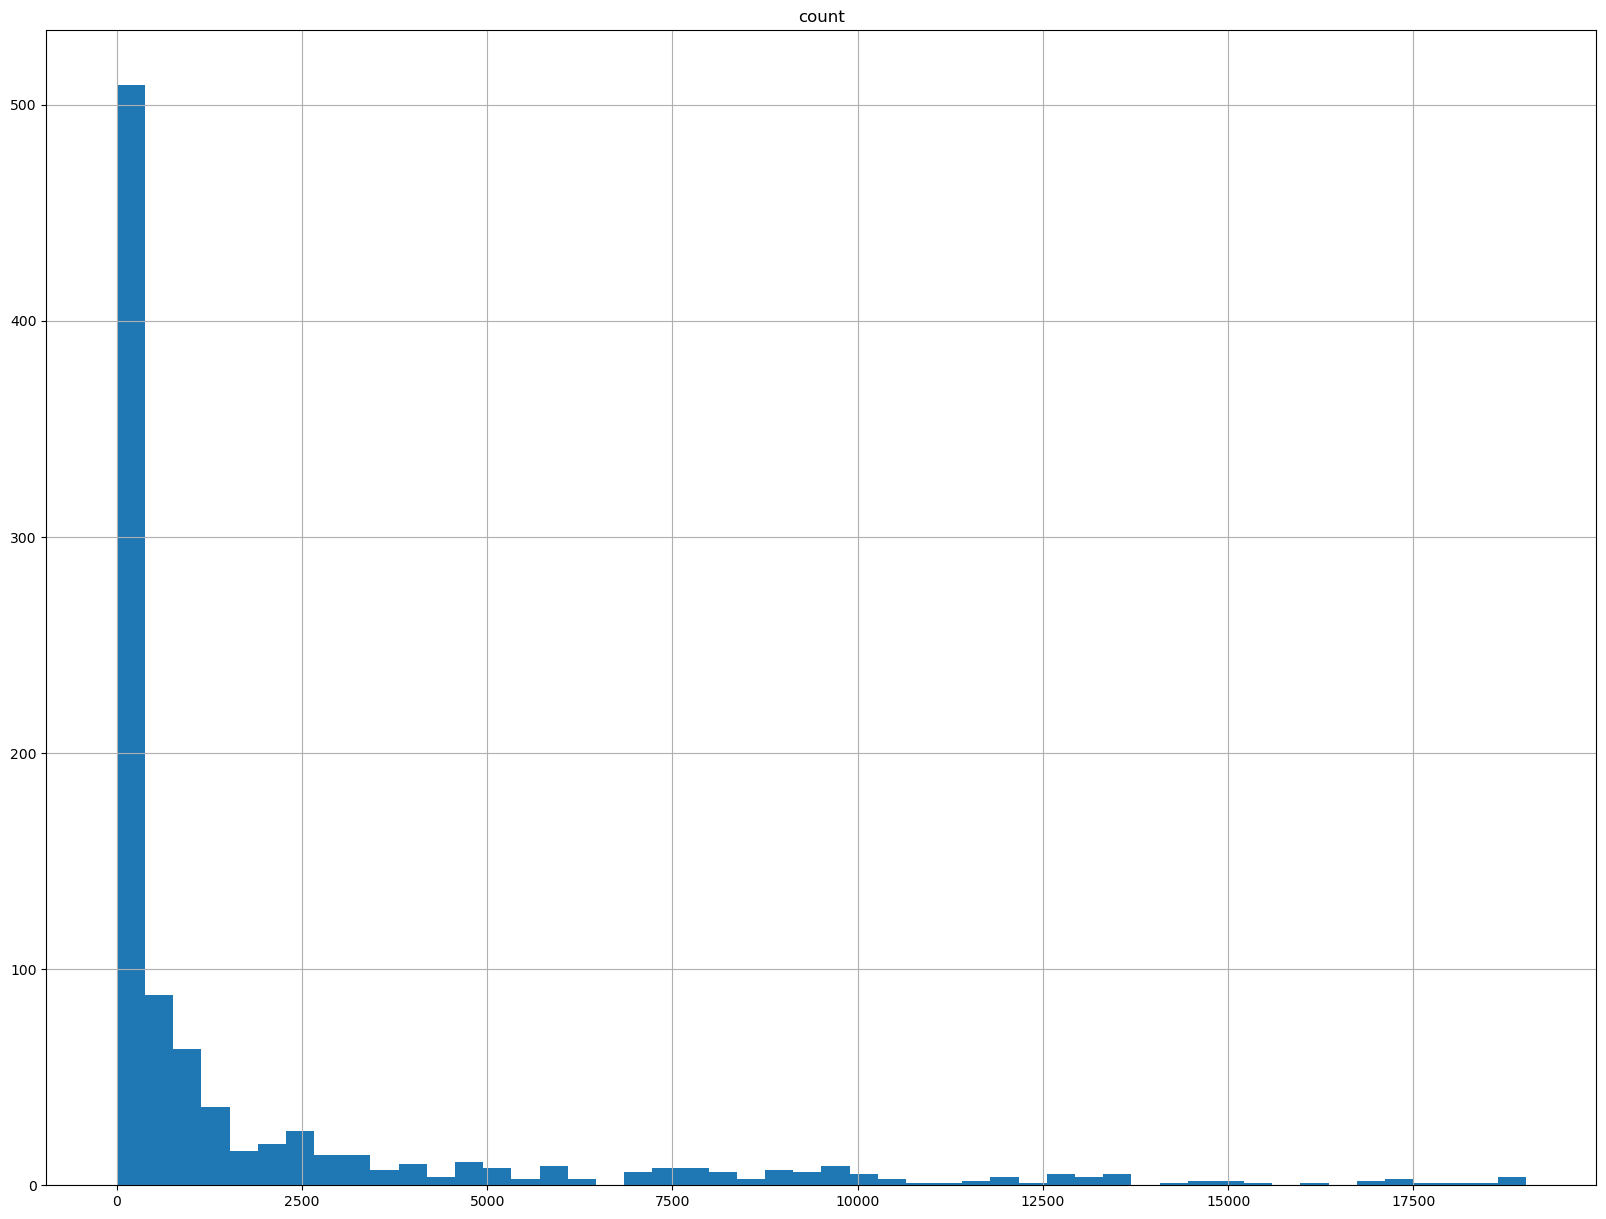

In [14]:
#hitograma dos dados, do count
preferencia_vacinas.hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
#colunas do dataset
preferencia_vacinas.columns

Index(['count', 'vacina_fabricante_nome', 'paciente_idade'], dtype='object')

In [16]:
#Quantos valores únicos tem a variáveis vacina_fabricante_nome?
preferencia_vacinas['vacina_fabricante_nome'].unique()

array(['SINOVAC/BUTANTAN', 'PFIZER', 'BUTANTAN', 'PFIZER - PEDIÁTRICA',
       'JANSSEN', 'PFIZER - PEDI?TRICA', 'ASTRAZENECA', 'SINOVAC',
       'PFIZER - PEDIÁTRICA MENOR DE 5 ANOS', 'Pendente Identificação',
       'ASTRAZENECA/FIOCRUZ', 'FUNDACAO OSWALDO CRUZ',
       'SINOVAC LIFE SCIENCES CO., LTD',
       'PFIZER MANUFACTURING BELGIUM NV - BELGICA',
       'JANSSEN PHARMACEUTICA NV', 'Pendente Identifica??o'], dtype=object)

Removeremos a coluna "idade"

In [17]:
preferencia_vacinas.drop(['paciente_idade'],axis=1,inplace=True)

In [18]:
preferencia_vacinas

,count,vacina_fabricante_nome
0,3177,SINOVAC/BUTANTAN
1,12874,PFIZER
2,407,BUTANTAN
3,4256,PFIZER
4,1690,PFIZER - PEDIÁTRICA
...,...,...
937,9600,ASTRAZENECA/FIOCRUZ
938,533,ASTRAZENECA/FIOCRUZ
939,2506,JANSSEN
940,109,ASTRAZENECA/FIOCRUZ


/tmp/ipykernel_6989/527238173.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(names, rotation=45)


Text(0.5, 0.98, 'Quantidade de aplicações por tipo de vacinas aplicadas fora do município de residência')

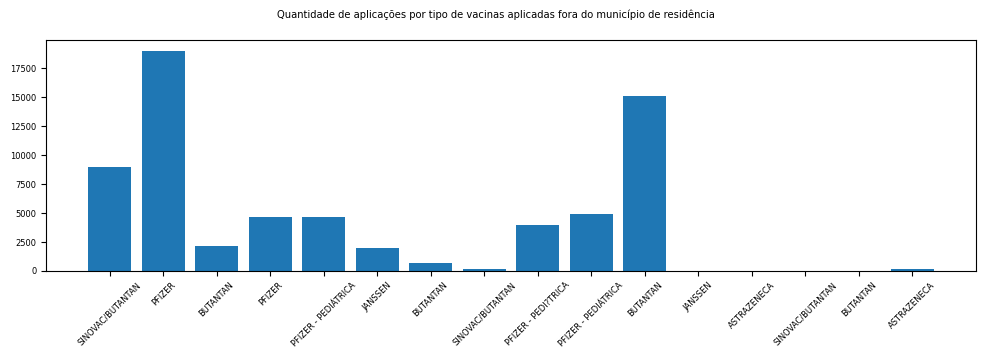

In [19]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html

plt.rcParams.update({'font.size': 6})
names = preferencia_vacinas['vacina_fabricante_nome']
values = preferencia_vacinas['count']

fig, axs = plt.subplots(1, 1, figsize=(12, 3))
axs.bar(names, values)
axs.set_xticklabels(names, rotation=45)
fig.suptitle('Quantidade de aplicações por tipo de vacinas aplicadas fora do município de residência')

In [21]:
preferencia_vacinas_mesmo_municipio = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.covid_vac_mg_1  where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)

/tmp/ipykernel_6989/550890773.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preferencia_vacinas_mesmo_municipio = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.covid_vac_mg_1  where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)


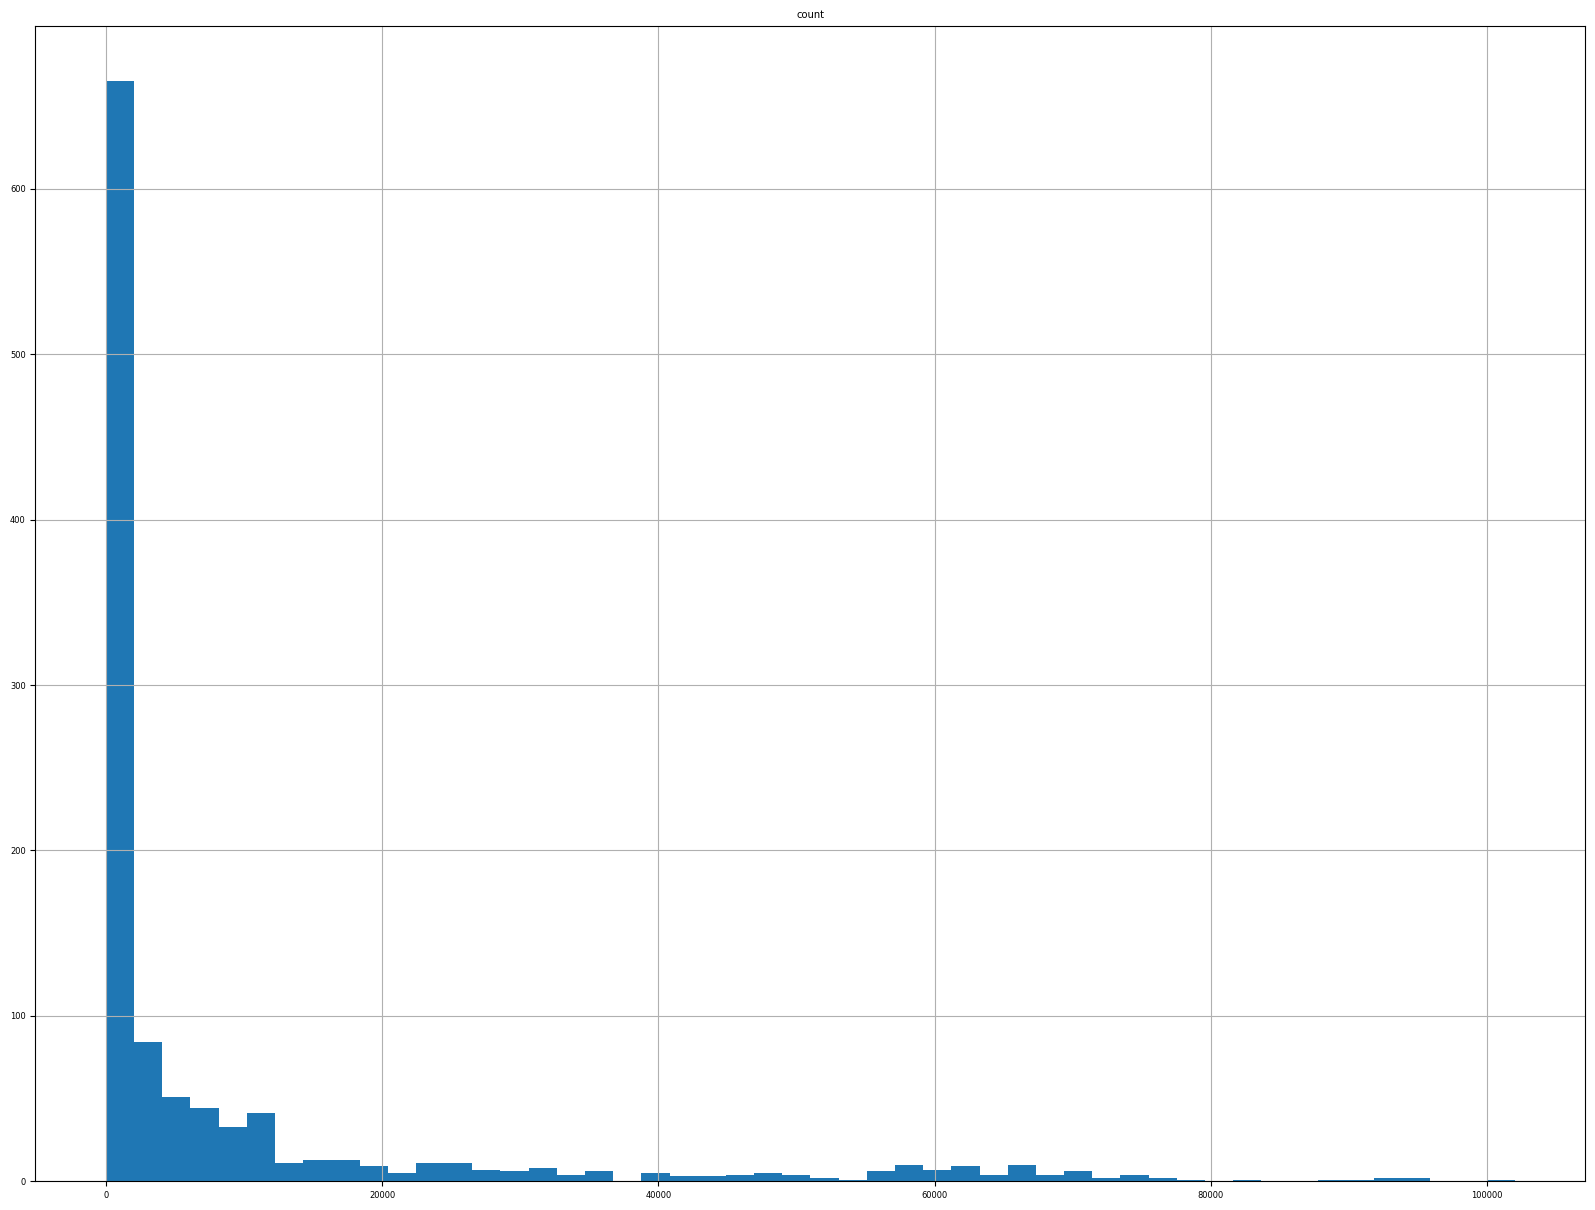

In [22]:
#hitograma dos dados
preferencia_vacinas_mesmo_municipio.hist(bins=50, figsize=(20,15))
plt.show()

/tmp/ipykernel_6989/1956884279.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(names, rotation=45)


Text(0.5, 0.98, 'Quantidade de aplicações por tipo de vacinas aplicadas no mesmo município de residência')

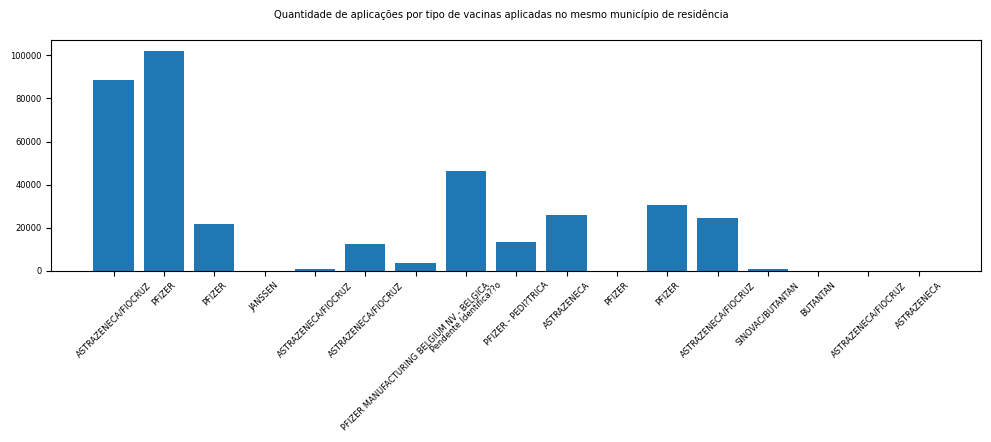

In [23]:
plt.rcParams.update({'font.size': 6})
names = preferencia_vacinas_mesmo_municipio['vacina_fabricante_nome']
values = preferencia_vacinas_mesmo_municipio['count']

fig, axs = plt.subplots(1, 1, figsize=(12, 3))
axs.bar(names, values)
axs.set_xticklabels(names, rotation=45)
fig.suptitle('Quantidade de aplicações por tipo de vacinas aplicadas no mesmo município de residência')

In [24]:
maiores = preferencia_vacinas_mesmo_municipio[preferencia_vacinas_mesmo_municipio['count']>80000]
maiores

,count,vacina_fabricante_nome,paciente_idade
10,102011,PFIZER,12
63,82882,ASTRAZENECA/FIOCRUZ,61
476,93220,PFIZER,17
575,91867,PFIZER,13
606,94634,PFIZER,15
702,95153,PFIZER,16
784,91217,PFIZER,14
1065,88481,ASTRAZENECA/FIOCRUZ,60


ETL resultante do visual ETL no Glue, se precisar.

```python
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

args = getResolvedOptions(sys.argv, ['JOB_NAME'])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# Script generated for node Amazon S3
AmazonS3_node1714854917742 = glueContext.create_dynamic_frame.from_options(format_options={"quoteChar": "\"", "withHeader": True, "separator": ";", "optimizePerformance": False}, connection_type="s3", format="csv", connection_options={"paths": ["s3://oficina-0973/opendatasus/mg/covid-vac-mg-1.csv"], "recurse": True}, transformation_ctx="AmazonS3_node1714854917742")

# Script generated for node AWS Glue Data Catalog
AWSGlueDataCatalog_node1714855054906 = glueContext.write_dynamic_frame.from_catalog(frame=AmazonS3_node1714854917742, database="oficina", table_name="covid-vac-mg-1", additional_options={"enableUpdateCatalog": True, "updateBehavior": "UPDATE_IN_DATABASE"}, transformation_ctx="AWSGlueDataCatalog_node1714855054906")

job.commit()
```

# Exercícios

## Registros repetidos

Para ver se existem registros repetidos, vamos ver quantas vezes cada número de ocorrências de um registro ocorre. Para isso, primeiro contamos os registros com base no ID dos pacientes e na data de aplicação da vacina (em teoria, um mesmo paciente não pode tomar mais de uma dose da vacina para COVID no mesmo dia), e, em seguida, contamos essa contagem, ou seja, quantos registros aparecem cada quantidade de vezes.

In [6]:
repeated_records = pd.read_sql("""SELECT counting, COUNT(*) AS n_of_occurences 
                                  FROM (
                                      SELECT COUNT(*) AS counting 
                                      FROM AwsDataCatalog.oficina.covid_vac_mg_1 
                                      GROUP BY paciente_id, vacina_dataaplicacao
                                  )
                                  GROUP BY counting
                                  ORDER BY counting;""", conn)
repeated_records

/tmp/ipykernel_6797/3635714522.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  repeated_records = pd.read_sql("""SELECT counting, COUNT(*) AS n_of_occurences


,counting,n_of_occurences
0,1,12001387
1,2,13027
2,3,84
3,4,2
4,7,1
5,8,1
6,11,1
7,13,1
8,14,1
9,17,1


A maioria dos registros aparece apenas uma vez, mas temos mais de 13 mil registros repetidos, inclusive com um registro que consta que um mesmo indivíduo se vacinou 19 vezes no mesmo dia!

Vamos ver isso num gráfico.

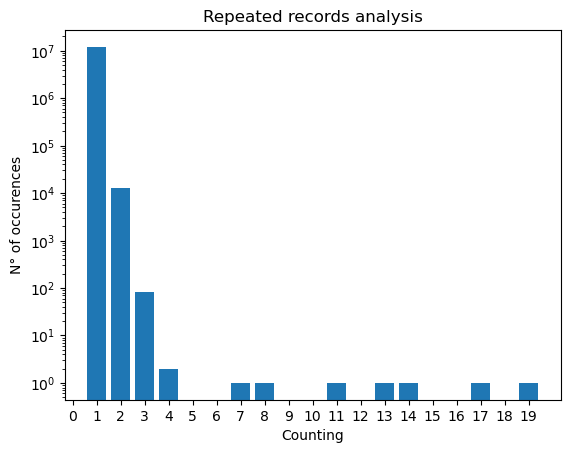

In [9]:
plt.bar(repeated_records["counting"], repeated_records["n_of_occurences"])
plt.yscale("log")
plt.xlabel('Counting')
plt.ylabel('N° of occurences')
plt.xticks(range(0, 20))
plt.title('Repeated records analysis')
plt.show()

## Mais de 3 doses

Agora, precisamos analisar se existem pessoas que receberam mais de 3 doses da vacina. Para isso, basta agruparmos os dados pelos IDs dos pacientes e contar quantas vezes cada quantidade dessas ocorre.

In [10]:
n_of_doses = pd.read_sql("""SELECT n_of_doses, COUNT(*) AS n_of_occurences 
                            FROM (
                                  SELECT COUNT(*) AS n_of_doses 
                                  FROM AwsDataCatalog.oficina.covid_vac_mg_1 
                                  GROUP BY paciente_id
                            )
                            GROUP BY n_of_doses
                            ORDER BY n_of_doses;""", conn)
n_of_doses

/tmp/ipykernel_6797/3406542615.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  n_of_doses = pd.read_sql("""SELECT n_of_doses, COUNT(*) AS n_of_occurences


,n_of_doses,n_of_occurences
0,1,7100037
1,2,1918442
2,3,310710
3,4,35770
4,5,2924
5,6,146
6,7,3
7,142,1


Vemos que quase 40 mil pessoas receberam mais de 3 doses da vacina (pelo menos é o que os dados nos dizem). No entanto, notamos um baita problema nessa base quando vemos um indivíduo recebendo nada menos que 142 doses!

Vamos plotar esses dados (o valor de 142 doses foi omitido para permitir uma visualização razoável do gráfico).

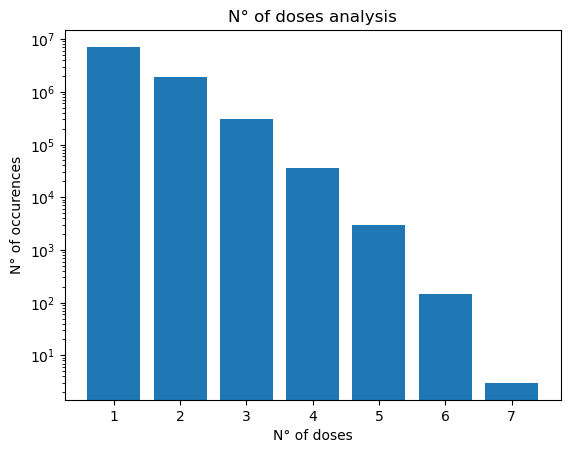

In [13]:
plt.bar(n_of_doses["n_of_doses"][:-1], n_of_doses["n_of_occurences"][:-1])
plt.yscale("log")
plt.xlabel('N° of doses')
plt.ylabel('N° of occurences')
plt.title('N° of doses analysis')
plt.show()

## 1 dose x 2 doses

Para determinar as quantidades de pessoas que tomaram a primeira e a segunda dose, precisamos agrupar os dados de acordo com os valores da coluna `vacina_descricao_dose`. No entanto, há um problema: não há um padrão totalmente estabelecido sobre como as informações dessa coluna estão descritas. Observe abaixo os valores únicos dessa coluna:

In [15]:
pd.read_sql("SELECT DISTINCT vacina_descricao_dose FROM AwsDataCatalog.oficina.covid_vac_mg_1;", conn)

/tmp/ipykernel_6797/799286449.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql("SELECT DISTINCT vacina_descricao_dose FROM AwsDataCatalog.oficina.covid_vac_mg_1;", conn)


,vacina_descricao_dose
0,5ª Dose Revacinação
1,4ª Dose Revacinação
2,Reforço
3,Dose Inicial
4,1ª Dose
5,3ª Dose
6,
7,1º Reforço
8,Revacinação
9,2º Reforço


Além de valores vazios, existem alguns nomes ambíguos, como "Dose" e "Dose adicional", tornando esse dado não tão preciso quanto gostaríamos. No entanto, ainda assim, com uma certa manipulação, ainda podemos fazer nossa análise. Depois de uma estudada nesses valores, classifiquei alguns como referentes à primeira dose da vacina e outros como referentes à segunda dose, agrupando todos esses rótulos em classes únicas. Dessa forma, abaixo está a consulta realizada.

In [18]:
doses_1x2 = pd.read_sql("""SELECT
                               CASE
                                   WHEN vacina_descricao_dose IN ('Dose Inicial', 'Única', '1ª Dose', '1ª Dose Fracionada') THEN '1° dose'
                                   WHEN vacina_descricao_dose IN ('2ª Dose') THEN '2° dose'
                               END AS supergroup, 
                               COUNT(*) AS counting
                            FROM AwsDataCatalog.oficina.covid_vac_mg_1
                            WHERE vacina_descricao_dose IN ('Dose Inicial', 'Única', '1ª Dose', '1ª Dose Fracionada', '2ª Dose')
                            GROUP BY
                                CASE
                                   WHEN vacina_descricao_dose IN ('Dose Inicial', 'Única', '1ª Dose', '1ª Dose Fracionada') THEN '1° dose'
                                   WHEN vacina_descricao_dose IN ('2ª Dose') THEN '2° dose'
                                END
                            ORDER BY counting DESC;""", conn)

doses_1x2

/tmp/ipykernel_6797/909191028.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  doses_1x2 = pd.read_sql("""SELECT


,supergroup,counting
0,1° dose,4308618
1,2° dose,3434913


Nota-se que o número de vacinados com a primeira dose é maior que o de vacinados com a segunda dose. No entanto, essa diferença é relativamente pequena, dando a entender que a maioria das pessoas que tomaram a primeira dose foram atrás de tomar a segunda também.

Vamos ver isso num gráfico.

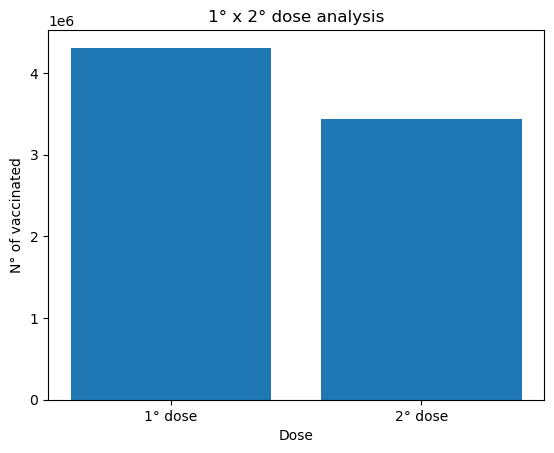

In [19]:
plt.bar(doses_1x2["supergroup"], doses_1x2["counting"])
plt.xlabel('Dose')
plt.ylabel('N° of vaccinated')
plt.title('1° x 2° dose analysis')
plt.show()

## Vacinados por município

Por fim, vamos descobrir a porcentagem de vacinados por município. Para essa análise, decidi considerar apenas os munícipios da base, ou seja, os municípios que receberam pacientes para vacinar, e não os municípios que tiveram alguém vacinado nessa cidade. Se fizesse o segundo, muitos municípios apareceriam com porcentagens pequenas, já que poucos de seus habitantes devem ter vindo para essas cidades da base para se vacinar. Assim, essa se tornou uma análise de quantas pessoas dessa região se vacinaram nessa mesma região, medido percentualmente para cada um de seus municípios. Além disso, foi considerado que, se uma pessoa tomou qualquer dose da vacina, ela foi vacinada. Com isso, foram pegos apenas os valores distintos de pacientes para não acontecer a contagem de pacientes mais de uma vez.

Feita a explicação, abaixo está o código da consulta referente a essa análise. Depois de muitos problemas com formatação, floats e parênteses, o código está funcionando.

In [117]:
vaccinated_per_city = pd.read_sql("""SELECT m.nome_do_munic_pio,
                                     CASE
                                         WHEN POSITION('(' IN m.popula__o_estimada) > 0 THEN
                                             (COUNT(DISTINCT v.paciente_id) / CAST(SUBSTRING(REPLACE(m.popula__o_estimada, '.', ''), 1, POSITION('(' IN REPLACE(m.popula__o_estimada, '.', '')) - 1) AS DOUBLE)) * 100
                                         ELSE
                                             (COUNT(DISTINCT v.paciente_id) / CAST(REPLACE(m.popula__o_estimada, '.', '') AS DOUBLE)) * 100
                                     END AS percentual_vacinados
                                     FROM AwsDataCatalog.oficina.municipios m
                                     INNER JOIN AwsDataCatalog.oficina.covid_vac_mg_1 v 
                                         ON (CAST(m.cod__uf AS VARCHAR) || SUBSTRING(CAST(m.cod__munic AS VARCHAR) FROM 1 FOR 4)) = v.estabelecimento_municipio_codigo
                                     GROUP BY m.nome_do_munic_pio, m.popula__o_estimada
                                     ORDER BY percentual_vacinados DESC;""", conn)

vaccinated_per_city

/tmp/ipykernel_6797/2933896185.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vaccinated_per_city = pd.read_sql("""SELECT m.nome_do_munic_pio,


,nome_do_munic_pio,percentual_vacinados
0,Patrocínio do Muriaé,682.016017
1,Confins,81.112567
2,Jeceaba,76.579771
3,Conceição do Mato Dentro,71.080399
4,Olaria,70.484061
...,...,...
848,Padre Carvalho,29.771110
849,Matias Cardoso,28.926056
850,Soledade de Minas,28.348860
851,São Romão,25.548651


Obviamente, temos um dado incorreto. Se não fosse, Patrocínio do Muriaé teria vacinado quase 7 vezes o seu número de habitantes, isso considerando apenas pessoas que são dessa cidade.

Vamos observar esses dados graficamente com um histograma, desconsiderando, é claro, nosso erro.

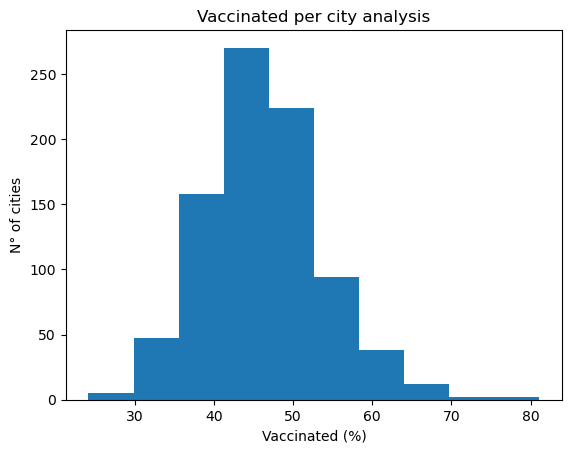

In [122]:
plt.hist(vaccinated_per_city["percentual_vacinados"].drop(0))
plt.xlabel('Vaccinated (%)')
plt.ylabel('N° of cities')
plt.title('Vaccinated per city analysis')
plt.show()